In [12]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import time
import datetime
import os

from utils import raw_data_path,dump_pickle,load_pickle,cal_log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import lightgbm as lgb
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12, 8]
params = {
    'max_depth': 4,                 #4
#    'min_data_in_leaf': 40,-
    'feature_fraction': 0.85,       #1
    'learning_rate': 0.04,          #0.04
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 2,
    'metric': 'binary_logloss',
}

if __name__ == '__main__':
    
    
    t0 = time.time()
    train_data = load_pickle(path='../data/train_final_onehot.pkl')    
    train_Y = train_data['is_trade']
    train_data.drop('is_trade', axis=1, inplace=True) 

    
    cv_data = load_pickle(path='../data/valid_final_onehot.pkl')
    cv_Y = cv_data['is_trade']
    cv_data.drop('is_trade', axis=1, inplace=True) 

    
    test_data = load_pickle(path='../data/test_final_onehot.pkl')
    test_data.drop('is_trade', axis=1, inplace=True) 

    
    test_file = 'round1_ijcai_18_test_a_20180301.txt'
    test = pd.read_table(raw_data_path + test_file,delim_whitespace=True)
    test_id = test.instance_id
    
#     'index',
    drop_cols = [ 'context_id', 'user_id','shop_id','item_id','item_brand_id']
    train_data.drop(drop_cols,axis=1,inplace=True)
    cv_data.drop(drop_cols,axis=1,inplace=True)
    test_data.drop(drop_cols,axis=1,inplace=True)
    
    print('train shap:',train_data.shape)
    print('cv shape', cv_data.shape)
    print('test shape', test_data.shape)
    
    lgb_train = lgb.Dataset(train_data.values, train_Y)
    lgb_cv = lgb.Dataset(cv_data.values, cv_Y)
    gbm = lgb.train(params=params,            #参数
                    train_set=lgb_train,      #要训练的数据
                    num_boost_round=5000,     #迭代次数
                    valid_sets=[lgb_train, lgb_cv],        #训练时需要评估的列表
                    verbose_eval=20,       #
                    early_stopping_rounds=500)
#     lgb.plot_importance(gbm, max_num_features=50)
#     plt.figure(figsize=(12, 8))
#     plt.show()
    predict_train = gbm.predict(train_data.values)
    predict_cv = gbm.predict(cv_data.values)
    predict_test = gbm.predict(test_data.values)
    
#     feat_imp = pd.Series(gbm.feature_importance(), index=train_data.columns).sort_values(ascending=False)

    
    print('训练损失:',log_loss(train_Y, predict_train))
    print('测试损失:',log_loss(cv_Y, predict_cv))
    t1 = time.time()
    print('训练时间:',t1 - t0)
    
    #全量评测
    train_data = pd.concat([train_data, cv_data],axis=0)
    train_Y = np.append(train_Y, cv_Y)
    
    lgb_train = lgb.Dataset(train_data.values, train_Y)
    gbm = lgb.train(params=params,            #参数
                    train_set=lgb_train,      #要训练的数据
                    num_boost_round=961,     #迭代次数
                    verbose_eval=True)
    predict_test = gbm.predict(test_data.values)
    print('训练损失:',cal_log_loss(gbm.predict(train_data.values), train_Y))
    
    submission = pd.DataFrame({'instance_id':test_id,'predicted_score':predict_test})
    print('预测正样本比例:',len(submission.loc[submission.predicted_score>=0.5])/len(submission))
    submission.to_csv(r'../result/lgb_{}.txt'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False, sep=' ',line_terminator='\r')
    
    
    


train shap: (288757, 235)
cv shape (189330, 235)
test shape (18371, 235)
Training until validation scores don't improve for 500 rounds.
[20]	training's binary_logloss: 0.288676	valid_1's binary_logloss: 0.286357
[40]	training's binary_logloss: 0.161429	valid_1's binary_logloss: 0.157541
[60]	training's binary_logloss: 0.115884	valid_1's binary_logloss: 0.110901
[80]	training's binary_logloss: 0.0999202	valid_1's binary_logloss: 0.094224
[100]	training's binary_logloss: 0.0946411	valid_1's binary_logloss: 0.0886059
[120]	training's binary_logloss: 0.0927662	valid_1's binary_logloss: 0.0867123
[140]	training's binary_logloss: 0.0918879	valid_1's binary_logloss: 0.0859509
[160]	training's binary_logloss: 0.0913625	valid_1's binary_logloss: 0.0855931
[180]	training's binary_logloss: 0.0909361	valid_1's binary_logloss: 0.0854187
[200]	training's binary_logloss: 0.0905714	valid_1's binary_logloss: 0.0852909
[220]	training's binary_logloss: 0.0902185	valid_1's binary_logloss: 0.0852177
[240]	

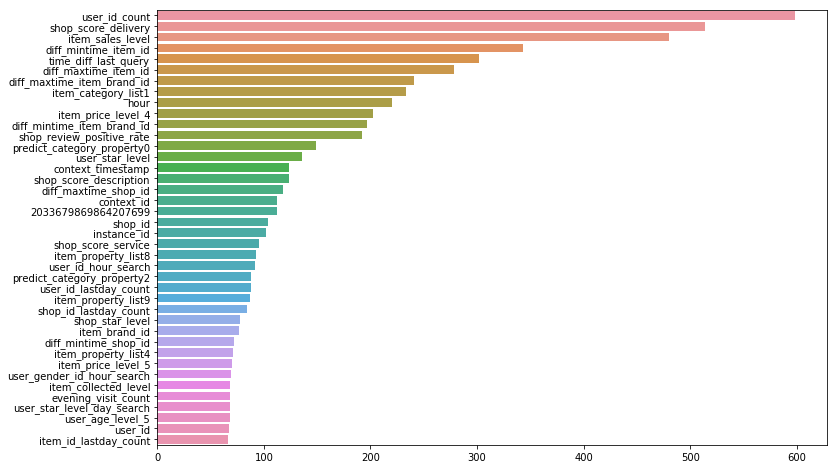

In [3]:
feat_imp = pd.Series(gbm.feature_importance(), index=train_data.columns).sort_values(ascending=False)[:40]
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.show()

0         1.000000
1         1.000000
2         1.000000
3         1.000000
4         1.000000
5         1.000000
6         0.976863
7         0.976863
8         0.976863
9         0.976863
10        0.976863
11        0.976863
12        0.976863
13        0.976863
14        0.976863
15        0.976863
16        0.976863
17        0.976863
18        0.976863
19        0.976863
20        0.976863
21        0.976863
22        0.976863
23        0.976863
24        0.976863
25        0.976863
26        0.976863
27        0.976863
28        0.976863
29        0.972113
            ...   
420687    0.970548
420688    0.970548
420689    0.970548
420690    0.971542
420691    0.971542
420692    0.971542
420693    0.971542
420694    0.971542
420695    0.971542
420696    0.971542
420697    0.971542
420698    0.971542
420699    0.971542
420700    0.971542
420701    0.971542
420702    0.971542
420703    0.971542
420704    0.971542
420705    0.971542
420706    0.971542
420707    0.971542
420708    0.